In [1]:
import torch
import joblib
import numpy as np
from torch import nn
import torch.optim as optim
from pathlib import Path
from tqdm import tqdm
from data.data_loader import DroneGraphDataset
from models.pretrained_model_loader import (
    load_pretrained_traj_model,
    extract_context_embeddings,
    extract_decoder_embeddings,
)
from models.tgn import DroneRelationModel

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = DroneGraphDataset(
    trajectory_csv="data/drone_states.csv",
    relationship_csv="data/drone_relations.csv",
    lookback=50,
    device=device,
)

sample = dataset[0]
print(sample["context_window"].shape)  # [50, num_drones, 4]
print(sample["current_features"].shape)  # [num_drones, 4]
print(sample["relationships"].shape)  # [num_pairs, 2]
# print(sample['labels'].shape)            # [num_pairs]


[Skipping] Flight 0, timestep 30.4 has 5 drones
[Skipping] Flight 1, timestep 33.267 has 1 drones
[Skipping] Flight 3, timestep 30.667 has 3 drones
[Skipping] Flight 4, timestep 33.9 has 1 drones
[Skipping] Flight 5, timestep 32.533 has 1 drones
[Skipping] Flight 6, timestep 31.367 has 2 drones
[Skipping] Flight 7, timestep 23.9 has 5 drones
[Skipping] Flight 8, timestep 29.4 has 5 drones
[Skipping] Flight 9, timestep 28.1 has 1 drones
[Skipping] Flight 10, timestep 34.5 has 4 drones
[Skipping] Flight 11, timestep 34.633 has 4 drones
[Skipping] Flight 12, timestep 33.733 has 3 drones
[Skipping] Flight 13, timestep 30.933 has 3 drones
[Skipping] Flight 14, timestep 33.8 has 4 drones
[Skipping] Flight 15, timestep 33.567 has 5 drones
[Skipping] Flight 16, timestep 31.7 has 5 drones
[Skipping] Flight 17, timestep 33.467 has 1 drones
[Skipping] Flight 18, timestep 35.733 has 1 drones
[Skipping] Flight 19, timestep 32.167 has 3 drones
[Skipping] Flight 21, timestep 31.5 has 5 drones
[Skippi

In [3]:
# Example usage
experiment_dir = Path("experiments/20251104_171301")

# Load model + config
model, config = load_pretrained_traj_model(experiment_dir, device)

# Load scalers
scaler_X = joblib.load(experiment_dir / "scaler_X.pkl")

# Dummy trajectory data (replace with your actual drone trajectory segment)
dummy_data = np.random.rand(100, 6 * 3).astype(
    np.float32
)  # 100 timesteps, 6 drones, xyz

# Extract embeddings
context_emb = extract_context_embeddings(
    model,
    traj_data=dummy_data,
    scaler_X=scaler_X,
    lookback=config["LOOK_BACK"],
    features_per_agent=9,
    device=device,
)

print("Context embeddings shape:", context_emb.shape)

Context embeddings shape: torch.Size([2, 256])


In [4]:
from torch.utils.data import Subset

flight_ids = dataset.flights
num_train = int(0.8 * len(flight_ids))
train_flights = flight_ids[:num_train]
test_flights = flight_ids[num_train:]

train_indices = [
    i for i, (fid, _) in enumerate(dataset.valid_indices) if fid in train_flights
]
test_indices = [
    i for i, (fid, _) in enumerate(dataset.valid_indices) if fid in test_flights
]

train_ds = Subset(dataset, train_indices)
test_ds = Subset(dataset, test_indices)

In [5]:
def balance_pairs(relationships, labels, max_neg_per_pos=1):
    """
    Undersample negative pairs so the ratio between negatives and positives
    is roughly `max_neg_per_pos` : 1.
    """
    pos_mask = labels == 1
    neg_mask = labels == 0

    pos_indices = torch.nonzero(pos_mask).squeeze(1)
    neg_indices = torch.nonzero(neg_mask).squeeze(1)

    num_pos = len(pos_indices)
    num_neg = len(neg_indices)
    if num_pos == 0 or num_neg == 0:
        return relationships, labels  # skip balancing if only one class

    # Sample negatives
    num_keep_neg = min(num_neg, num_pos * max_neg_per_pos)
    sampled_neg_indices = neg_indices[torch.randperm(num_neg)[:num_keep_neg]]

    # Combine and shuffle
    keep_indices = torch.cat([pos_indices, sampled_neg_indices])
    keep_indices = keep_indices[torch.randperm(len(keep_indices))]

    return relationships[keep_indices], labels[keep_indices]

In [6]:
def hybrid_topk(probs, k=1, threshold=0.5):
    """
    probs: [num_friendly, num_unauth] (softmax probabilities per friendly)
    k: max number of relations per friendly to keep
    threshold: minimum probability to keep an edge
    
    Returns:
        binary mask: same shape as probs, 1 where selected, else 0
    """
    num_friendly, num_unauth = probs.shape
    selection = torch.zeros_like(probs)

    topk_vals, topk_idx = torch.topk(probs, k, dim=1)
    for i in range(num_friendly):
        keep_mask = topk_vals[i] > threshold
        selection[i, topk_idx[i, keep_mask]] = 1.0

    return selection

In [7]:
def train_epoch(
    model, loader, optimizer, criterion, scaler_X, pretrained_model, config
):
    model.train()
    pretrained_model.train()
    total_loss = 0
    for batch in tqdm(
        loader, desc="Training", leave=True, ncols=100, dynamic_ncols=True
    ):
        context_window = (
            batch["context_window"].squeeze(0).to(device)
        )  # [50, num_drones, 4]
        current_features = batch["current_features"].squeeze(0).to("cpu")
        relationships = batch["relationships"].squeeze(0).to("cpu")
        labels = batch["labels"].squeeze(0).float().to("cpu")

        # # --- New: target indices per friendly drone ---
        # target_indices = batch["target_indices"].squeeze(0).to(device)  # [num_friendly]

        # num_friendly = batch["num_friendly"]
        # num_unauth = batch["num_unauth"]

        relationships, labels = balance_pairs(relationships, labels, max_neg_per_pos=1)
        # relationships = batch["relationships"].squeeze(0).to(device)

        # Extract context embeddings from pretrained model
        context_emb = extract_decoder_embeddings(
            pretrained_model,
            traj_data=context_window[:, :, :9].reshape(50, -1),
            scaler_X=scaler_X,
            lookback=config["LOOK_BACK"],
            features_per_agent=9,
            device="cpu",
        )

        preds = model(current_features, context_emb, relationships)
        loss = criterion(preds, labels)

        # probs, logits = model(current_features, context_emb, relationships, num_friendly, num_unauth)
        # loss = criterion(logits, target_indices)  # logits: [num_friendly, num_unauth]

        # custom weighting
        # weights = torch.where(labels == 1, 2.0, 1.0)  # higher weight for 1s
        # loss = (weights * loss).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [8]:
# from models.vgae import GCNLayer, VGAE, reconstruction_loss, kl_divergence, build_adj_from_pairs
# from tqdm import tqdm

# # --- TRAINING LOOP ---
# def train_epoch_vgae(vgae_model, loader, optimizer, scaler_X, pretrained_model, config, device="cpu"):
#     vgae_model.train()
#     pretrained_model.train()
#     total_loss = 0.0

#     for batch in tqdm(loader, desc="Training", leave=True, ncols=100, dynamic_ncols=True):
#         context_window = batch["context_window"].squeeze(0).to(device)  # [T, N, 4]
#         relationships = batch["relationships"].squeeze(0).to(device)
#         labels = batch["labels"].squeeze(0).float().to(device)

#         relationships, labels = balance_pairs(relationships, labels, max_neg_per_pos=1)

#         # === 1. Extract context embeddings ===
#         context_emb = extract_decoder_embeddings(
#             pretrained_model,
#             traj_data=context_window[:, :, :3].reshape(context_window.shape[0], -1),
#             scaler_X=scaler_X,
#             lookback=config["LOOK_BACK"],
#             features_per_agent=3,
#             device=device,
#         )  # [num_drones, hidden_dim]

#         num_nodes = context_emb.size(0)
#         adj = build_adj_from_pairs(num_nodes, relationships, labels, directed=True, self_loops=True, device=device)

#         # === 2. Forward VGAE ===
#         scores, mu, logvar = vgae_model(context_emb, adj)

#         # === 3. Compute losses ===
#         recon_loss = reconstruction_loss(scores, adj)
#         kld = kl_divergence(mu, logvar)
#         loss = recon_loss + kld  # (you can scale kld if needed, e.g., loss = recon_loss + 0.1 * kld)

#         # === 4. Backprop ===
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     return total_loss / len(loader)

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)


@torch.no_grad()
def evaluate(model, loader, scaler_X, pretrained_model, config, show_confusion=True):
    model.eval()
    pretrained_model.eval()
    preds_all, labels_all = [], []
    inspected = 0
    inspect_n = 9

    for batch in tqdm(
        loader, desc="Evaluating", leave=True, ncols=100, dynamic_ncols=True
    ):
        context_window = batch["context_window"].squeeze(0).cpu().numpy()
        current_features = batch["current_features"].squeeze(0).to("cpu")
        labels = batch["labels"].squeeze(0).float().to("cpu")
        relationships = batch["relationships"].squeeze(0).to(device)

        # target_indices = batch["target_indices"].squeeze(0).to("cpu")
        # num_friendly = batch["num_friendly"]
        # num_unauth = batch["num_unauth"]

        context_emb = extract_decoder_embeddings(
            pretrained_model,
            traj_data=context_window[:, :, :9].reshape(50, -1),
            scaler_X=scaler_X,
            lookback=config["LOOK_BACK"],
            features_per_agent=9,
            device=device,
        )

        preds = model(current_features, context_emb, relationships)
        # preds = torch.sigmoid(preds)  # Apply sigmoid to get probabilities

        # probs, logits = model(current_features, context_emb, relationships, num_friendly, num_unauth)
        
        # pred_mask = hybrid_topk(probs, k=1, threshold=0.4)

        # # Flatten for metrics: make sure labels shape matches preds shape
        # labels_matrix = labels.view(num_friendly, num_unauth)
        # y_true = labels_matrix.cpu().numpy().flatten()
        # y_pred = pred_mask.cpu().numpy().flatten()

        # preds_all.append(torch.tensor(y_pred))
        # labels_all.append(torch.tensor(y_true))

        preds_all.append(preds)
        labels_all.append(labels)

        # Inspect first few data points
        if inspected < inspect_n:
            print(
                f"Predicted logits: {preds[:inspect_n].detach().cpu().numpy().flatten()}"
            )
            print(
                f"Actual labels: {labels[:inspect_n].detach().cpu().numpy().flatten()}"
            )

            inspected += 1

    preds_all = torch.cat(preds_all)
    labels_all = torch.cat(labels_all)

    print(preds_all.min().item(), preds_all.max().item())
    print(labels_all.min().item(), labels_all.max().item())

    # Binary predictions
    y_true = labels_all.cpu().numpy().astype(int)
    y_pred = (preds_all.cpu().numpy() > 0.5).astype(int)

    # Compute accuracy
    acc = (y_true == y_pred).mean().item()

    # Compute accuracy
    # acc = (preds_all == labels_all).float().mean().item()
    # print(f"Accuracy: {acc:.3f}")
    
    # Optional: print precision/recall/F1
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    # compute ROC AUC and ROC curve
    try:
        auc = roc_auc_score(y_true, y_pred)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
    except ValueError:
        auc = np.nan
        fpr, tpr = [0, 1], [0, 1]  # fallback for degenerate cases

    print(f"Accuracy: {acc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")  # >>> CHANGED

    if show_confusion:
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
        disp.plot(cmap="Blues", colorbar=False)
        plt.title("Confusion Matrix")
        plt.show()
        
        # >>> ADDED: ROC curve
        plt.figure(figsize=(5, 5))
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

        # >>> ADDED: Precision–Recall curve
        precisions, recalls, _ = precision_recall_curve(y_true, y_pred)
        plt.figure(figsize=(5, 5))
        plt.plot(recalls, precisions)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision–Recall Curve")
        plt.grid(True)
        plt.show()


    # if show_confusion:
    #     y_true = labels_all.cpu().numpy()
    #     y_pred = preds_all.cpu().numpy()
    #     cm = confusion_matrix(y_true, y_pred, labels=list(range(num_unauth)))
    #     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #     disp.plot(cmap="Blues", colorbar=False)
    #     plt.title("Confusion Matrix")
    #     plt.show()

    #     # Optional: print precision/recall/F1 (micro-averaged)
    #     precision = precision_score(y_true, y_pred, average="micro", zero_division=0)
    #     recall = recall_score(y_true, y_pred, average="micro", zero_division=0)
    #     f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
    #     print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    return acc

In [10]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# # --- EVALUATION LOOP ---
# @torch.no_grad()
# def evaluate_vgae(vgae_model, loader, scaler_X, pretrained_model, config, device="cpu", show_confusion=True):
#     vgae_model.eval()
#     pretrained_model.eval()
#     preds_all, labels_all = [], []

#     for batch in tqdm(loader, desc="Evaluating", leave=True, ncols=100, dynamic_ncols=True):
#         context_window = batch["context_window"].squeeze(0).to(device)
#         relationships = batch["relationships"].squeeze(0).to(device)
#         labels = batch["labels"].squeeze(0).float().to(device)

#         # === 1. Extract context embeddings ===
#         context_emb = extract_decoder_embeddings(
#             pretrained_model,
#             traj_data=context_window[:, :, :3].reshape(context_window.shape[0], -1),
#             scaler_X=scaler_X,
#             lookback=config["LOOK_BACK"],
#             features_per_agent=3,
#             device=device,
#         )

#         num_nodes = context_emb.size(0)
#         adj_true = build_adj_from_pairs(num_nodes, relationships, labels, directed=True, self_loops=True, device=device)

#         # === 2. VGAE forward ===
#         scores, mu, logvar = vgae_model(context_emb, adj_true)
#         adj_pred = torch.sigmoid(scores)

#         # Extract predictions for given relationships
#         preds = adj_pred[relationships[:, 0], relationships[:, 1]]
#         preds_all.append(preds)
#         labels_all.append(labels)

#     preds_all = torch.cat(preds_all)
#     labels_all = torch.cat(labels_all)

#     print(preds_all.min().item(), preds_all.max().item())
#     print(labels_all.min().item(), labels_all.max().item())

#     # === 3. Compute metrics ===
#     y_true = labels_all.cpu().numpy().astype(int)
#     y_pred = (preds_all.cpu().numpy() > 0.5).astype(int)

#     acc = (y_true == y_pred).mean().item()

#     if show_confusion:
#         cm = confusion_matrix(y_true, y_pred)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
#         disp.plot(cmap="Blues", colorbar=False)
#         plt.title("Confusion Matrix")
#         plt.show()

#         precision = precision_score(y_true, y_pred, zero_division=0)
#         recall = recall_score(y_true, y_pred, zero_division=0)
#         f1 = f1_score(y_true, y_pred, zero_division=0)
#         print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

#     return acc

Evaluating:   0%|          | 10/5511 [00:00<01:52, 49.10it/s]

Predicted logits: [0.13400762 0.09062996 0.6630777  0.5425361  0.4684913  0.01261311
 0.36069405 0.5411853  0.00823379]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.11818822 0.07697029 0.7007565  0.5406866  0.46632507 0.0123812
 0.3265295  0.5050094  0.00707411]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.12128314 0.08329844 0.6958792  0.5399114  0.46263868 0.01229998
 0.28720146 0.45721102 0.0059267 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.12205975 0.09021213 0.6960451  0.55064535 0.45996505 0.01294855
 0.279196   0.4364274  0.00578303]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.1163452  0.09026425 0.70111096 0.5746672  0.4628787  0.01421189
 0.3215035  0.47140735 0.00699508]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.10751405 0.08535586 0.71398985 0.5831051  0.46103513 0.01446665
 0.37286377 0.5147195  0.00855311]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits:

Evaluating: 100%|██████████| 5511/5511 [01:50<00:00, 49.72it/s]


1.544253819870528e-13 0.9543619751930237
0.0 1.0
Accuracy: 0.777, Precision: 0.729, Recall: 0.526, F1: 0.611, AUC: 0.714


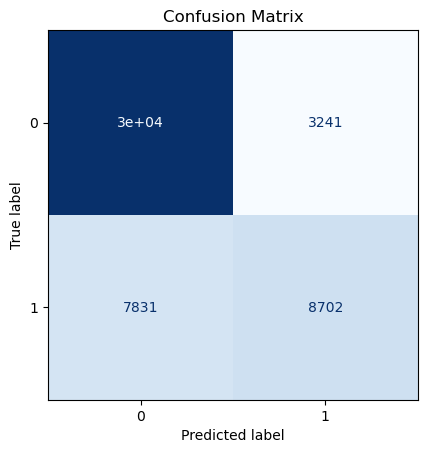

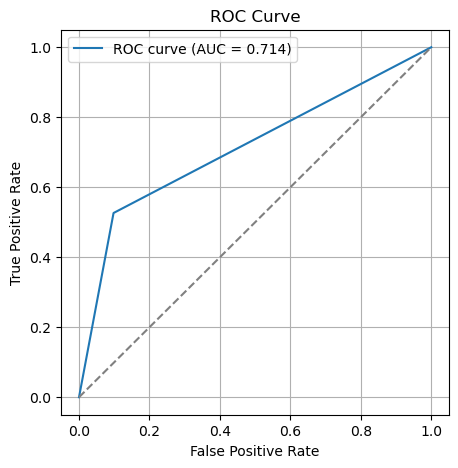

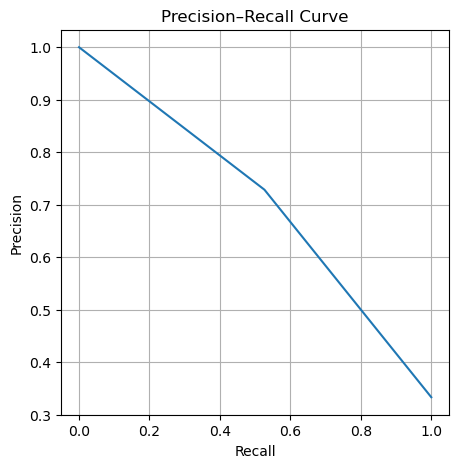

Epoch 1: Loss=0.4275, Test Acc=0.777


Evaluating:   0%|          | 10/5511 [00:00<01:53, 48.27it/s]

Predicted logits: [0.01269382 0.01643407 0.8446124  0.7170826  0.44655943 0.00694997
 0.4762911  0.71405464 0.0100158 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.01210128 0.01476964 0.8533256  0.71459824 0.44138628 0.00686371
 0.43768165 0.69663525 0.00866192]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.01209946 0.01634218 0.8554582  0.7103114  0.43128708 0.00687882
 0.38694078 0.6632045  0.00726613]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.01217477 0.01846296 0.85707    0.7099742  0.4145225  0.00718415
 0.37435588 0.6384307  0.00709233]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.01147716 0.0188332  0.8588369  0.7178662  0.39964792 0.00770788
 0.4263361  0.6577695  0.00854481]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.01052948 0.01818684 0.86103475 0.7140651  0.38506207 0.00776379
 0.48186263 0.68202615 0.01034052]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits

Evaluating: 100%|██████████| 5511/5511 [01:50<00:00, 49.92it/s]

4.787772257064596e-18 0.9494646191596985
0.0 1.0
Accuracy: 0.817, Precision: 0.795, Recall: 0.607, F1: 0.688, AUC: 0.764


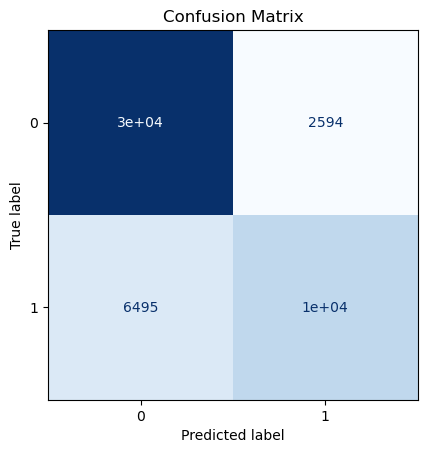

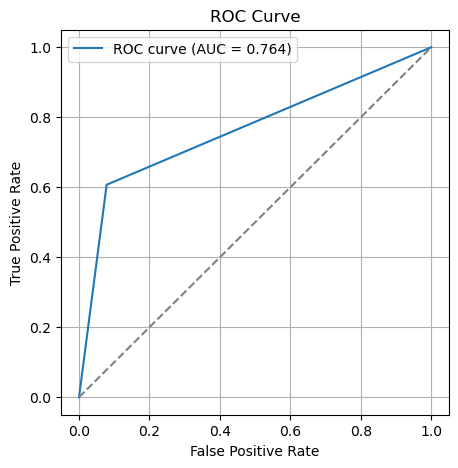

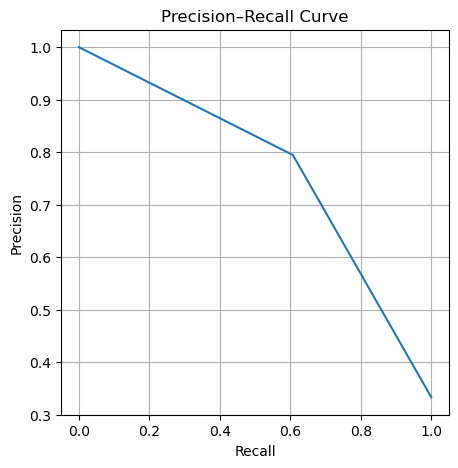

Epoch 2: Loss=0.2947, Test Acc=0.817


Evaluating:   0%|          | 10/5511 [00:00<01:51, 49.31it/s]

Predicted logits: [0.01207058 0.02525118 0.86695194 0.8114965  0.322757   0.00567811
 0.65013134 0.75909036 0.01897897]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.01349934 0.02747491 0.8628944  0.810133   0.31750396 0.00567279
 0.62271374 0.75541997 0.01668655]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.01290539 0.02885157 0.86378175 0.80865556 0.30651632 0.00573924
 0.5765322  0.741032   0.0142482 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.01291484 0.03205452 0.86423403 0.8075539  0.28986514 0.00591587
 0.5666837  0.72485816 0.0138823 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.01236241 0.03342247 0.86574274 0.80932856 0.2715172  0.006194
 0.6157927  0.7251784  0.01635773]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.01201468 0.03452637 0.86599505 0.8092056  0.25573802 0.0061867
 0.64844424 0.7163062  0.01941634]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [

Evaluating: 100%|██████████| 5511/5511 [01:50<00:00, 49.76it/s]


6.689580361081548e-22 0.9613661766052246
0.0 1.0
Accuracy: 0.838, Precision: 0.803, Recall: 0.680, F1: 0.736, AUC: 0.798


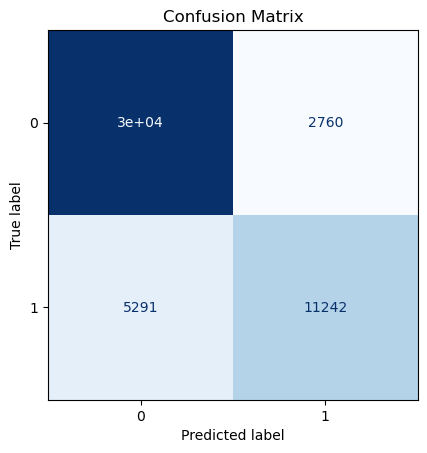

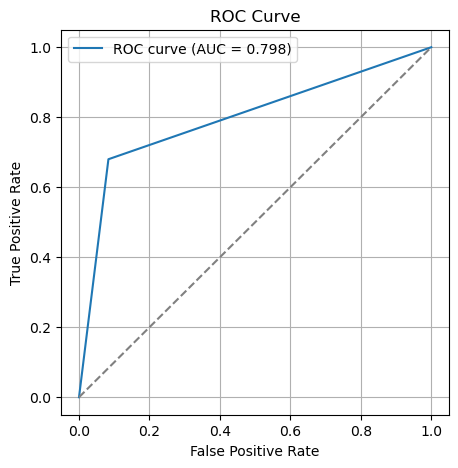

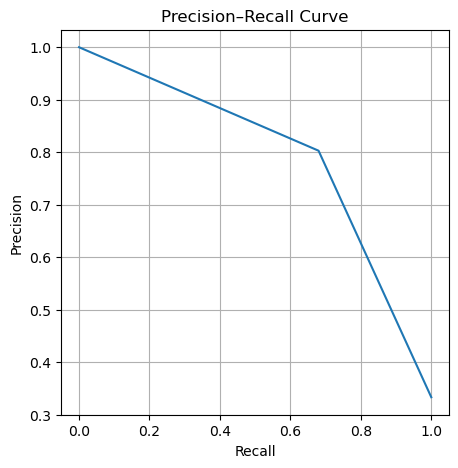

Epoch 3: Loss=0.2647, Test Acc=0.838


Evaluating:   0%|          | 10/5511 [00:00<01:52, 49.02it/s]

Predicted logits: [0.00847555 0.01551672 0.78698725 0.7948572  0.31102905 0.00102468
 0.43507135 0.7660489  0.00916393]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.0100617  0.0183885  0.81878924 0.7925423  0.30562153 0.00102534
 0.3915292  0.75070286 0.0081422 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.0095707  0.01916374 0.814025   0.7893724  0.29275382 0.00103618
 0.34567577 0.72662234 0.00700257]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.00957534 0.02150569 0.8167357  0.7862852  0.27618974 0.00105292
 0.33353257 0.7076617  0.00681948]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.00908929 0.02270105 0.82071584 0.7876457  0.26578444 0.00107942
 0.37740758 0.71014744 0.00788768]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.00892683 0.02420457 0.83104795 0.7845744  0.25349697 0.00106635
 0.43474182 0.7178668  0.00914355]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits

Evaluating: 100%|██████████| 5511/5511 [01:50<00:00, 49.95it/s]

1.769243433163844e-24 0.9573058485984802
0.0 1.0
Accuracy: 0.819, Precision: 0.812, Recall: 0.594, F1: 0.687, AUC: 0.763


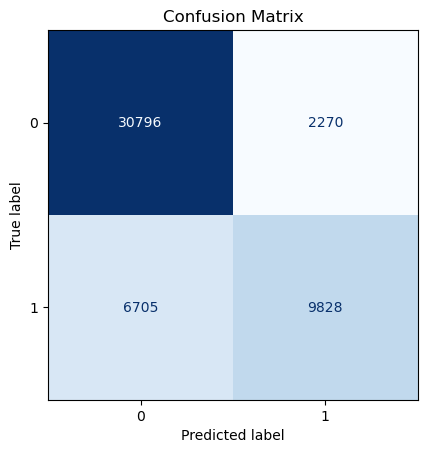

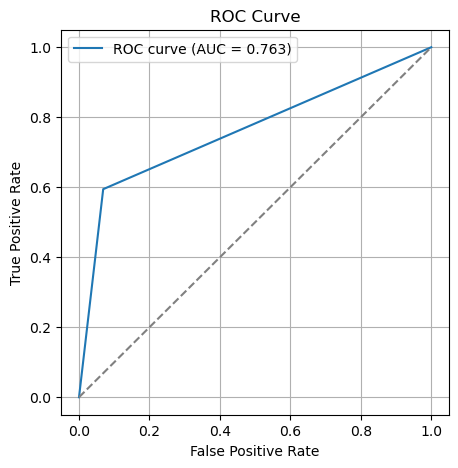

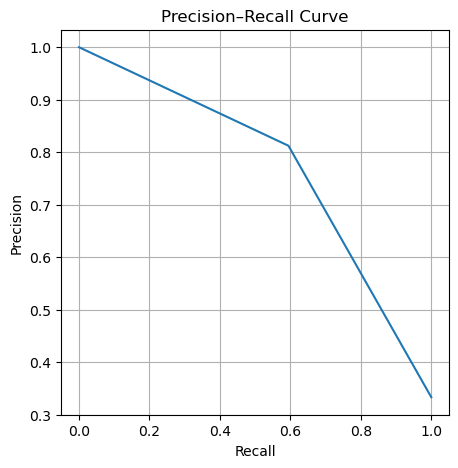

Epoch 4: Loss=0.2479, Test Acc=0.819


Evaluating:   0%|          | 10/5511 [00:00<01:53, 48.56it/s]

Predicted logits: [0.00531605 0.02103234 0.87621033 0.8746571  0.19481674 0.00113519
 0.44178015 0.8576114  0.01414818]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.00584936 0.02087624 0.8877671  0.8727062  0.18987843 0.00114825
 0.41039586 0.8544103  0.01325132]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.00552331 0.02268043 0.8880234  0.8679859  0.17840159 0.00116611
 0.3757548  0.84187025 0.01213746]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.00558592 0.02616478 0.8904011  0.85896784 0.1586903  0.00115161
 0.36958453 0.82978356 0.01199536]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.00532564 0.02787512 0.89142966 0.85100585 0.14029895 0.0011222
 0.40545285 0.8224424  0.01301788]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.00504563 0.02803233 0.89480746 0.8428959  0.12796657 0.00109182
 0.44684672 0.8120243  0.01401102]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits:

Evaluating: 100%|██████████| 5511/5511 [01:50<00:00, 49.86it/s]

6.090089413131712e-24 0.981934666633606
0.0 1.0
Accuracy: 0.839, Precision: 0.828, Recall: 0.654, F1: 0.731, AUC: 0.793


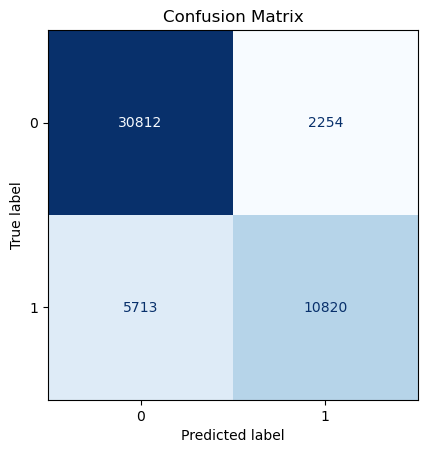

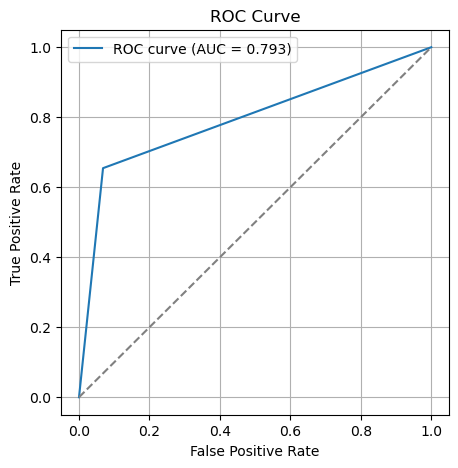

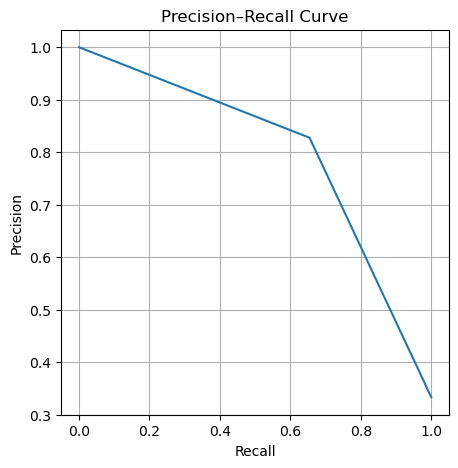

Epoch 5: Loss=0.2337, Test Acc=0.839


Training:  10%|▉         | 2085/21725 [00:44<06:58, 46.92it/s]


KeyboardInterrupt: 

In [11]:
# Load pretrained trajectory model
model_traj, config = load_pretrained_traj_model(experiment_dir, device)
scaler_X = joblib.load(experiment_dir / "scaler_X.pkl")

# Initialize new relation model
relation_model = DroneRelationModel(context_dim=model_traj.dec_hidden_size).to(device)
# relation_model = DroneRelationModel(
#     context_dim=model_traj.enc_hidden_size * 2,
# ).to(device)

# optimizer = optim.Adam(relation_model.parameters(), lr=1e-3)
optimizer = optim.Adam(
    [
        {"params": relation_model.parameters(), "lr": 1e-4},
        {"params": model_traj.parameters(), "lr": 1e-4},
    ]
)
# pos_weight = torch.tensor([2.0], device=device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCEWithLogitsLoss()

criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(20):
    loss = train_epoch(
        relation_model, train_ds, optimizer, criterion, scaler_X, model_traj, config
    )
    acc = evaluate(relation_model, test_ds, scaler_X, model_traj, config)
    print(f"Epoch {epoch + 1}: Loss={loss:.4f}, Test Acc={acc:.3f}")


# # Load pretrained trajectory model
# model_traj, config = load_pretrained_traj_model(experiment_dir, device)
# scaler_X = joblib.load(experiment_dir / "scaler_X.pkl")

# # Initialize VGAE model (instead of DroneRelationModel)
# vgae_model = VGAE(
#     in_dim=model_traj.dec_hidden_size,  # same as your current context_dim
#     hidden_dim=128,
#     latent_dim=64,
#     decoder_type="dot",  # or "bilinear" for directed
#     device=device
# ).to(device)

# optimizer = torch.optim.Adam([
#     {"params": vgae_model.parameters(), "lr": 1e-4},
#     {"params": model_traj.parameters(), "lr": 1e-4},
# ])

# # Training loop
# for epoch in range(10):
#     loss = train_epoch_vgae(vgae_model, train_ds, optimizer, scaler_X, model_traj, config, device)
#     acc = evaluate_vgae(vgae_model, test_ds, scaler_X, model_traj, config, device)
#     print(f"Epoch {epoch+1}: Loss={loss:.4f}, Test Acc={acc:.3f}")